## Import

In [247]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_score
from dateutil.relativedelta import relativedelta
from matplotlib.ticker import StrMethodFormatter



## Clustering

In [248]:
df = pd.read_csv('db.csv')

In [249]:
display(df.head())
print()
display(df.columns)

,CustomerID,Region,State,City,PostalCode,AddressID,Category,SubCategory,CategoryID,RowID,...,Segment,Country,ProductID,ProductName,Sales,Quantity,Discount,Profit,CataloguePrice,SupplierPrice
0,CG-12520,South,Kentucky,Henderson,42420,A000001,Furniture,Bookcases,C0001,1,...,Consumer,United States,FUR-BO-10001798,Bush Somerset Collection Bookcase,26195.00,2,0.00,4191.00,13097.00,11002.00
1,CG-12520,South,Kentucky,Henderson,42420,A000001,Furniture,Chairs,C0002,2,...,Consumer,United States,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",73194.00,3,0.00,21958.00,24398.00,17078.00
2,DV-13045,West,California,Los Angeles,90036,A000002,Office Supplies,Labels,C0013,3,...,Corporate,United States,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,1462.00,2,0.00,687.00,731.00,387.00
3,SO-20335,South,Florida,Fort Lauderdale,33311,A000003,Furniture,Tables,C0003,4,...,Consumer,United States,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,95757.00,5,0.45,-38303.00,34821.00,26812.00
4,SO-20335,South,Florida,Fort Lauderdale,33311,A000003,Office Supplies,Storage,C0012,5,...,Consumer,United States,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,2236.00,2,0.20,251.00,1397.00,992.00


Index(['CustomerID', 'Region', 'State', 'City', 'PostalCode', 'AddressID',
       'Category', 'SubCategory', 'CategoryID', 'RowID', 'OrderID',
       'OrderDate', 'ShipDate', 'ShipMode', 'CustomerName', 'Segment',
       'Country', 'ProductID', 'ProductName', 'Sales', 'Quantity', 'Discount',
       'Profit', 'CataloguePrice', 'SupplierPrice'],
      dtype='object')

## CLV(Customer Lifespan Value)

CLV = Customer Value * Average Customer Lifespan

CV = Average Order Value * Average Purchase Frequency Rate

CLV = Average Order Value * Average Purchase Frequency Rate * Customer Lifetime

In [271]:
# AOV
aov = df['Sales'].sum() / df['OrderID'].count() / 100
aov

229.85561136682009

In [272]:
# APFR
apfr = df['OrderID'].count() / df['CustomerID'].nunique()
apfr

12.602774274905423

In [273]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df_cl = df.groupby('CustomerID').agg({'OrderDate': lambda x: relativedelta(x.max(), x.min()).years * 12 + relativedelta(x.max(), x.min()).months}).reset_index()
df_cl.columns = ['CustomerID', 'Lifespan']

print(df_cl)

    CustomerID  Lifespan
0     AA-10315        38
1     AA-10375        43
2     AA-10480        35
3     AA-10645        40
4     AB-10015        32
..         ...       ...
788   XP-21865        45
789   YC-21895        37
790   YS-21880        35
791   ZC-21910        36
792   ZD-21925        33

[793 rows x 2 columns]


In [274]:
df_cl['Lifespan'].sum() / 793 / 12

2.6956704497688104

In [275]:
# CLV
clv = aov * apfr * df_cl['Lifespan']
df_clv = pd.DataFrame({
    'CustomerID': df_cl["CustomerID"], 
    'LifetimeValue': clv
})

pd.set_option('display.float_format', lambda x: '%.2f' % x)

display(df_clv.head())
df_clv.shape

,CustomerID,LifetimeValue
0,AA-10315,110079.10
1,AA-10375,124563.19
2,AA-10480,101388.64
3,AA-10645,115872.74
4,AB-10015,92698.19


(793, 2)

## Dealing with outliers

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='LifetimeValue'>

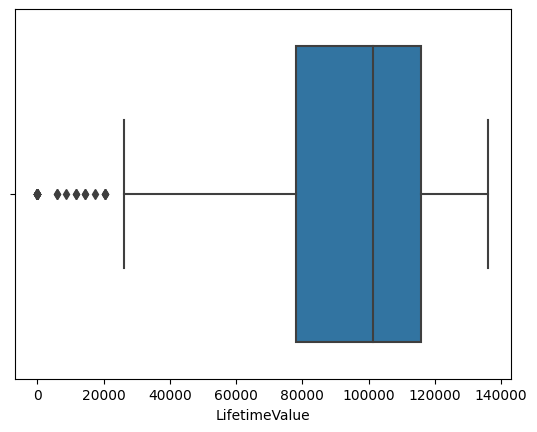

In [276]:
# Checking outliers

sns.boxplot(x='LifetimeValue', data=df_clv)

In [278]:
# Removing outliers with IQR

def remove_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]

df_clv['LifetimeValue'] = remove_outliers(df_clv['LifetimeValue'])

df_clv = df_clv.dropna()
print(df_clv.head())
df_clv.shape

  CustomerID  LifetimeValue
0   AA-10315      110079.10
1   AA-10375      124563.19
2   AA-10480      101388.64
3   AA-10645      115872.74
4   AB-10015       92698.19


(762, 2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='LifetimeValue'>

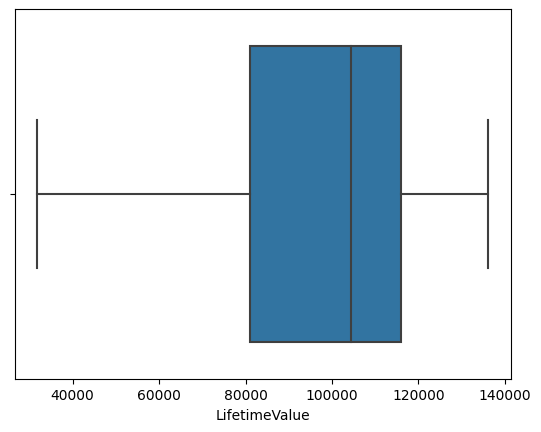

In [279]:
sns.boxplot(x='LifetimeValue', data=df_clv)

## Feature Scaling

In [280]:
scaler = StandardScaler()
df_clv['LifetimeValue_Scaled'] = scaler.fit_transform(df_clv[['LifetimeValue']])

In [281]:
# Finding optimal K with Elbow Method

inertia = []
k_values = range(1, 6)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clv[['LifetimeValue_Scaled']])
    inertia.append(kmeans.inertia_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

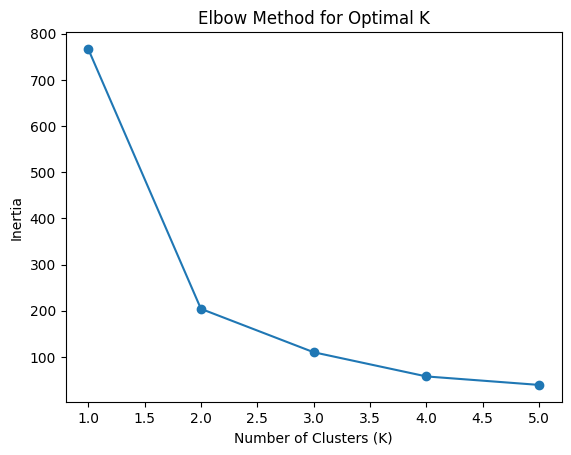

In [259]:
# Visualization Elbow Method

plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [282]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_clv[['LifetimeValue_Scaled']])

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df_clv[['LifetimeValue_Scaled']], cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

For n_clusters=2, the silhouette score is 0.659798903771683
For n_clusters=3, the silhouette score is 0.5479793914410063
For n_clusters=4, the silhouette score is 0.5692205901491778
For n_clusters=5, the silhouette score is 0.5664449604106123
For n_clusters=6, the silhouette score is 0.5637943986976501
For n_clusters=7, the silhouette score is 0.5651498519545787
For n_clusters=8, the silhouette score is 0.5672354685506601


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=2, the silhouette score is 0.659798903771683


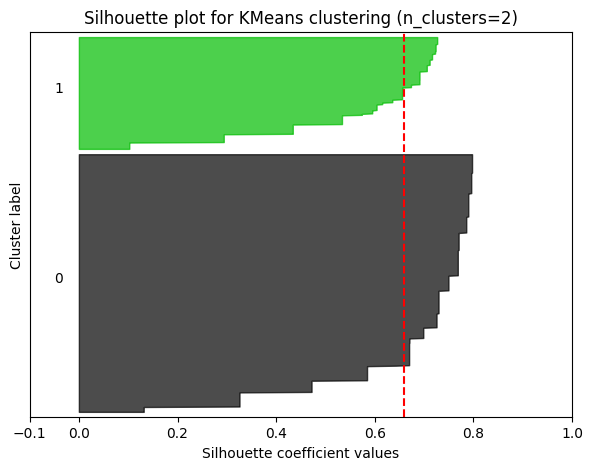

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=3, the silhouette score is 0.5481156244513371


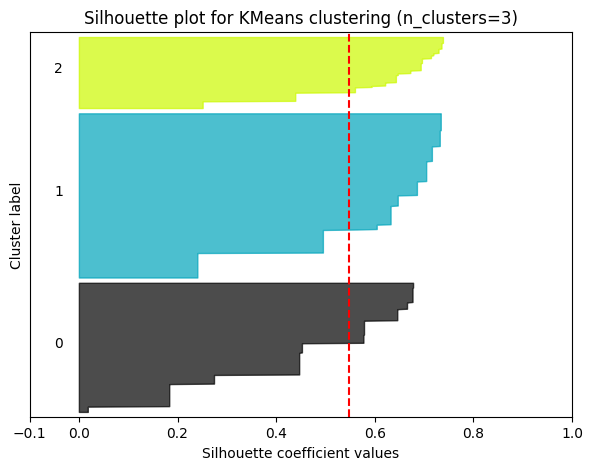

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=4, the silhouette score is 0.5711058631429591


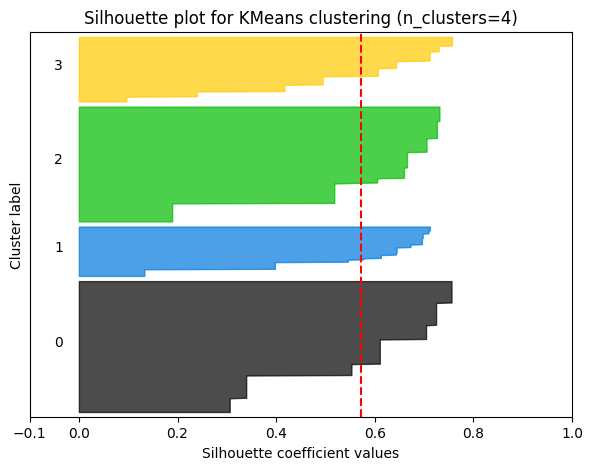

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=5, the silhouette score is 0.5633120749489693


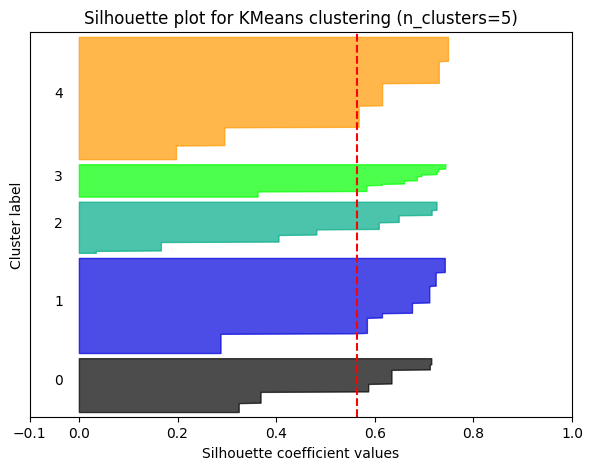

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=6, the silhouette score is 0.552399681210011


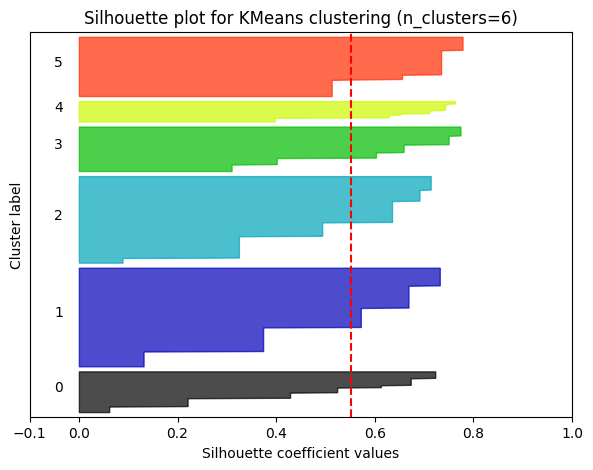

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=7, the silhouette score is 0.5668385909562154


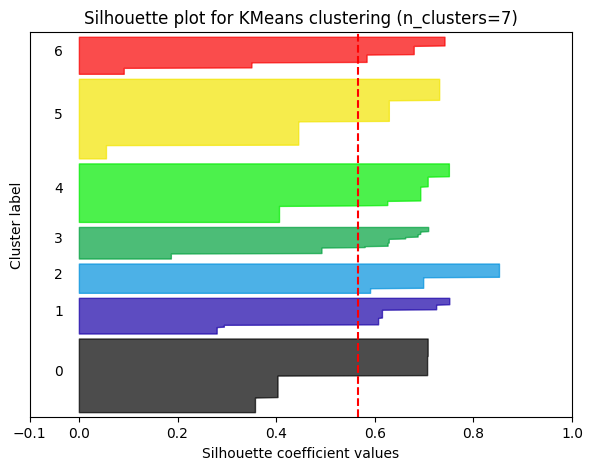

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=8, the silhouette score is 0.5672354685506601


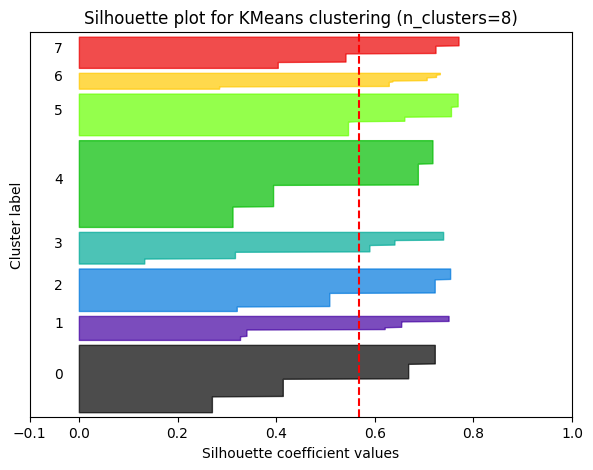

In [290]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(df_clv[['LifetimeValue_Scaled']])

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df_clv[['LifetimeValue_Scaled']], cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

    # silhouette plot for each cluster
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    # 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(df_clv) + (num_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clv[['LifetimeValue_Scaled']])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_clv[['LifetimeValue_Scaled']], cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_clv[['LifetimeValue_Scaled']], cluster_labels)

    y_lower = 10
    for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / num_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot for KMeans clustering (n_clusters={})".format(num_clusters))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

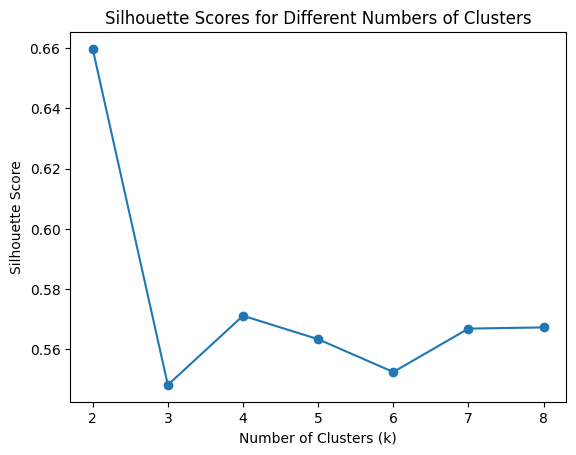

In [291]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df_clv[['LifetimeValue_Scaled']]

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

silhouette_scores = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [283]:
# Performing clustering with optimal K 

optimal_k = 2  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clv['Cluster'] = kmeans.fit_predict(df_clv[['LifetimeValue_Scaled']])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Customer Lifetime Value')

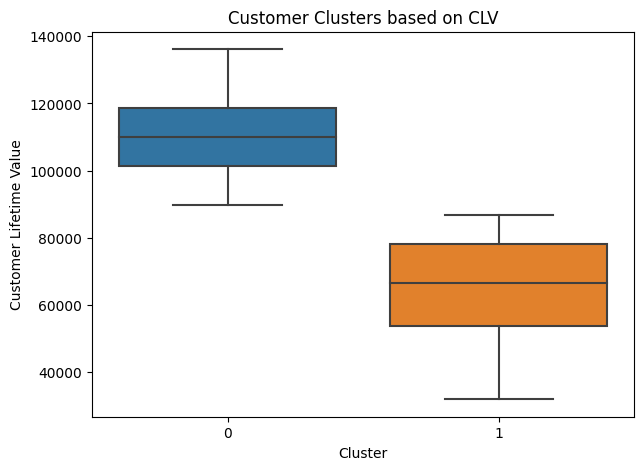

In [289]:
plt.figure(figsize=(7, 5))

sns.boxplot(x='Cluster', y='LifetimeValue', data=df_clv)
plt.title('Customer Clusters based on CLV')
plt.xlabel('Cluster')
plt.ylabel('Customer Lifetime Value')

In [285]:
# Check the result 

display(df_clv[['CustomerID', 'LifetimeValue', 'Cluster']].head())

,CustomerID,LifetimeValue,Cluster
0,AA-10315,110079.10,0
1,AA-10375,124563.19,0
2,AA-10480,101388.64,0
3,AA-10645,115872.74,0
4,AB-10015,92698.19,0


In [304]:
df_clv_max= df_clv.groupby('Cluster', as_index=False)['LifetimeValue'].max()
display(df_clv_max)

df_clv_min = df_clv.groupby('Cluster', as_index=False)['LifetimeValue'].min()
display(df_clv_min)

df_clv_cnt = df_clv.groupby('Cluster', as_index=False)['LifetimeValue'].count()
display(df_clv_cnt)

df_clv_sum = df_clv.groupby('Cluster', as_index=False)['LifetimeValue'].sum()
display(df_clv_sum)

,Cluster,LifetimeValue
0,0,136150.46
1,1,86904.55


,Cluster,LifetimeValue
0,0,89801.37
1,1,31865.00


,Cluster,LifetimeValue
0,0,531
1,1,231


,Cluster,LifetimeValue
0,0,58906801.88
1,1,15112701.52


In [287]:
df_clv.to_csv('/Users/penguin/Desktop/CodeAcademy/Ecommerce/Tables/Cluster.csv',index=False)